<a href="https://colab.research.google.com/github/Juanes1793/Proyectos-Data-Science/blob/main/Google_Colabs/Time_Series/03_BIDIRECTIONAL_LSTM_Secuence_to_Secuence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIDIRECTIONAL LSTM SECUENCE TO SECUENCE

En algunos problemas de series de tiempo, puede ser beneficioso permitir que el modelo LSTM aprenda la secuencia de entrada tanto hacia adelante como hacia atrás y concatene ambas interpretaciones. Esto se denomina BIDIRECTIONAL LSTM.

Podemos implementar una BIDIRECTIONAL LSTM  para el pronóstico de series de tiempo univariadas envolviendo la primera capa oculta en una capa contenedora denominada bidireccional.

Un ejemplo de cómo definir un LSTM bidireccional para leer la entrada tanto hacia adelante como hacia atrás es el siguiente.

<img src = "https://discuss.pytorch.org/uploads/default/original/3X/3/4/34b90de7962ead49de23d901fac44f1da4789571.png">

#Conextualización del problema
El objetivo de este notebook es el de aplicar el método de Bidirectional LSTM secuence to secuence para el pronóstico de la demanda en una microrred utilizando series de tiempo. La base de datos de la demanda de la potencia eléctrica de un microrred utilizada es la de una microrred ubicada en un campus en San Diego, Estados Unidos , la cual tiene 75.844 datos registrados desde el 01/01/2018 hasta el 29/02-2020. La información fue recolectada con un tiempo de muestreo de 15 minutos. Con la información de la demanda nos permite realizar pronóstico a futuro de cada 15 minutos con un horizonte de pronóstico para la demanda de la microrred de un día hacia el futuro

### Se importan las librerías

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import datetime



### Lectura del Dataset

In [ ]:
url = "https://raw.githubusercontent.com/Juanes1793/Proyectos-Data-Science/main/Base_datos/DemandCharge.csv"
#df = pd.read_csv("DemandCharge.csv")
df = pd.read_csv(url)

In [ ]:
df_2 = df.copy()
df_2.rename(columns = {'TotalCampusLoad':'Demanda_Campus'}, inplace = True)
df_2['DateTime'] = pd.to_datetime(df_2.DateTime)
df_2.sort_values(by=['DateTime'], axis=0, ascending=True, inplace=True)
df_2.reset_index(inplace=True, drop=True)
df_2 = df_2.set_index('DateTime')


In [ ]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

Se programa una función sequence to sequence que servirá como ventana o sliding window para nuestra serie de tiempo

In [ ]:
Demanda = df_2["Demanda_Campus"]																# Se obtiene una sola columna del dataFrame que será a la que se le hace la predicción.
demanda_lista = df_2["Demanda_Campus"].tolist()									# Se convierte la columna del dataFrame a lista

# choose a number of time steps

n_steps_in, n_steps_out = 96, 1																# Se usa 96 porque es el número de datos por día que se obtienen cada 15 minutos de la microrred

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
X, y = split_sequence(demanda_lista,n_steps_in,n_steps_out)                # Se aplica la función teniendo en cuenta los datos de la demanda y el número de pasos, en este caso 96

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X) 
y = y.reshape(-1,1)
y_scaled = scaler.fit_transform(y) 

n_features = 1                                              # Se asigna 1 porque estamos trabajando con una serie univariada
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], n_features))         # Se redimensiona el arreglo dependiendo del número de características de este y condiciones iniciales
y_scaled = y_scaled.reshape((y_scaled.shape[0], y_scaled.shape[1], n_features)) 

Se reparten los datos en entrenamiento y prueba.
80% para prueba y 20% para entrenamiento


In [ ]:
X_train,y_train = X_scaled[:60598],y_scaled[:60598]                        # Datos de entrenamiento
X_test,y_test = X_scaled[60598:],y_scaled[60598:]                          # Datos de prueba



Se define el modelo

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(100, activation='relu',return_sequences=True)))  #Línea de código adicional 
model.add(Bidirectional(LSTM(100, activation='relu',return_sequences=True)))  #Línea de código adicional
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')

In [ ]:
history = model.fit(X_train,y_train, validation_split = 0.1, epochs=20)   

Epoch 1/20
1705/1705 [==============================] - 236s 131ms/step - loss: 425.0367 - val_loss: 0.0155
Epoch 2/20
1705/1705 [==============================] - 226s 133ms/step - loss: 0.0106 - val_loss: 0.0123
Epoch 3/20
1705/1705 [==============================] - 225s 132ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 4/20
1705/1705 [==============================] - 226s 132ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 5/20
1705/1705 [==============================] - 223s 131ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 6/20
1705/1705 [==============================] - 222s 130ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 7/20
1705/1705 [==============================] - 222s 130ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 8/20
1705/1705 [==============================] - 225s 132ms/step - loss: 0.0098 - val_loss: 0.0134
Epoch 9/20
1705/1705 [==============================] - 219s 129ms/step - loss: 0.0098 - val_loss: 0.0111
Epoch 10/20
1705/1705 [=====================

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


### Gráfica de comparación de model loss

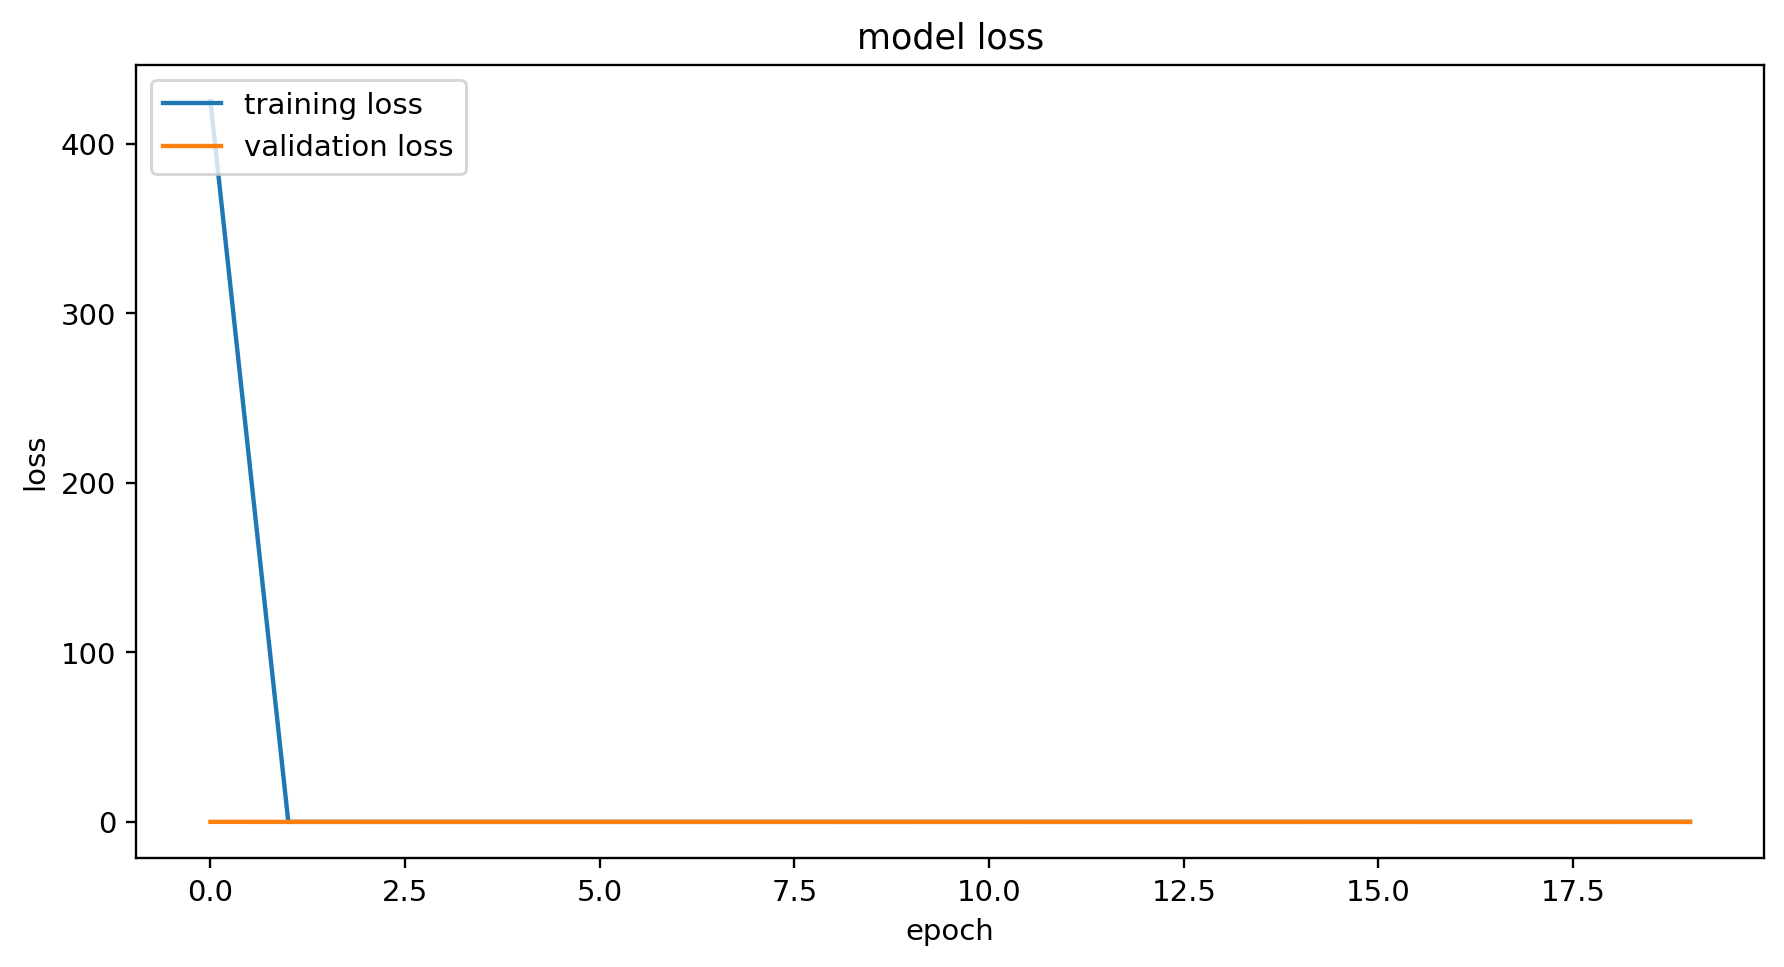

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

### Se organizan los datos para organizarse en un dataFrame

In [ ]:
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)                        # Se realizan las predicciones
#print(yhat)

# Importanción de librería 
from functools import reduce
Lista_predict = yhat.tolist()                                  # Se transforma el array en una nested list (lista dentro de listas) 
prediccion = reduce(lambda x,y: x+y, Lista_predict)            # Luego se transforma en una lista de una sola dimensión          


y_test = y_test.tolist()                                       # Se transforma el array en una nested list (lista dentro de listas) 
y_test1 = reduce(lambda x,y: x+y, y_test)                      # Se transforma el array en una nested list (lista dentro de listas)  

### Se escalan los datos a su valor real 

In [ ]:
#Se vuelven a escalar los datos a su valor real para los datos de prueba
ytest_real = scaler.inverse_transform(y_test1)
ytest_real = ytest_real.tolist()
ytest_real1 = reduce(lambda x,y: x+y, ytest_real)  

#Se vuelven a escalar los datos a su valor real para las predicciones

yreal_prediccion = scaler.inverse_transform(prediccion) 
yreal_prediccion = yreal_prediccion.tolist()
yreal_prediccion1 = reduce(lambda x,y: x+y, yreal_prediccion)   

### Se muestran los datos comparados en un dataframe y en una gráfica con sus valores reales

In [ ]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 


train_results = pd.DataFrame(data={'Train Predictions':yreal_prediccion1 , 'Actuals':ytest_real1})
train_results

,Train Predictions,Actuals
0,37709.548548,38044.49
1,37793.823863,38031.04
2,37800.950634,38453.51
3,38171.645431,39728.97
4,39409.076571,39681.40
...,...,...
15145,31059.161402,31552.81
15146,31346.114750,31364.09
15147,31187.322087,31236.65
15148,31065.079990,31096.75


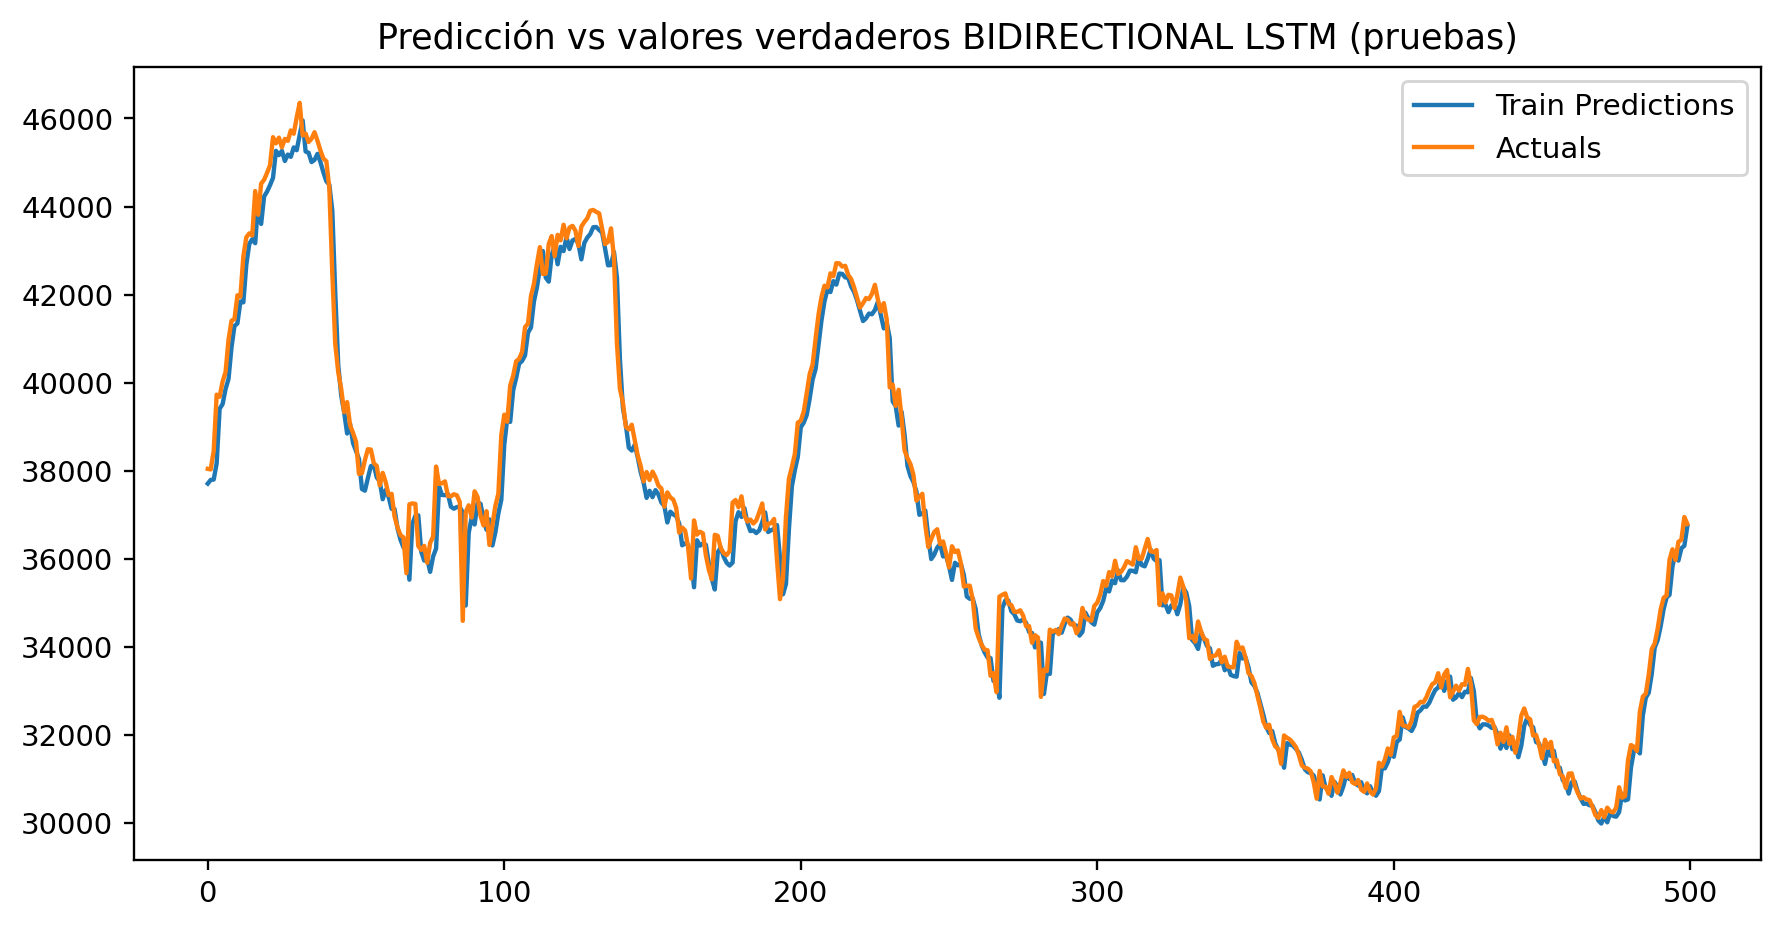

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos BIDIRECTIONAL LSTM (pruebas)")
plt.legend();

### Métricas de medición

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error #Error absoluto, cuadrado, y cuadrado logarítmico.



print(f"Test Mean Squared Error: {mean_squared_error(y_test1, prediccion)}")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test1, prediccion)}")
print(f"Test Mean squared log error: {mean_squared_log_error(y_test1, prediccion)}")
mape = mean_absolute_percentage_error(y_test1,prediccion)
print('Mean absolute percentage error (MAPE): %f' % mape)

Test Mean Squared Error: 0.0002568430905472624
Test Mean Absolute Error: 0.01143002852000625
Test Mean squared log error: 0.0001543248778743114
Mean absolute percentage error (MAPE): 4.487634
